In [92]:
#Training and testing my model with data that was labeled based only on 143Nd/144Nd versus 87Sr/86Sr values. 

import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import torch.nn.init as init
import torch.optim as optim


device = "cuda" #to use my GPU

final_data=pd.read_csv('../DataFP/final_data.csv')


In [79]:
#Choosing  only the data that has location
final_data.dropna(subset=['latitude', 'longitude'], inplace=True)
print(final_data)
print(len(final_data))

       labelSrNd   latitude   longitude  rb87_sr86  sr87_sr86  nd143_nd144   
0              3  33.686551  130.304669     0.6262   0.705200     0.512554  \
1              3  33.687129  130.304404     0.5366   0.705170     0.512661   
2              3  33.688168  130.301608     0.5165   0.705010     0.512694   
3              3  36.988056  138.505000        NaN   0.703871     0.512919   
4              3  43.076423  141.635239        NaN   0.705267     0.512626   
...          ...        ...         ...        ...        ...          ...   
13853          1 -63.000000  -64.000000        NaN   0.702640     0.512980   
13854          1 -63.000000  -64.000000        NaN   0.702830     0.512960   
13855          1 -60.333500  -29.709667        NaN   0.703100     0.513016   
13856          1 -60.200000  -29.869833        NaN   0.702940     0.513063   
13857          1 -60.054167  -29.970167        NaN   0.703102     0.513001   

       sm147_nd144  pb206_pb204  pb207_pb204  pb208_pb204  ... 

In [124]:
labels_SrNd = final_data['labelSrNd']
lat = final_data['latitude']
long = final_data['longitude']

min_latitude = -90
max_latitude = 90
min_longitude = -180
max_longitude = 180

#Normalizing the latitude and longitude values using min-max scaling established before
lat = (lat - min_latitude) / (max_latitude - min_latitude)
long = (long - min_longitude) / (max_longitude - min_longitude)
#Normalizing my other features (chemical composition) with a Gaussian distribution 
normalized_final_data = (final_data - final_data.mean()) / (final_data.std())

#Concatenating all my data: labels and normalized features (locations and chemical composition)
normalized_final_data['labelSrNd'] = labels_SrNd
normalized_final_data['latitude'] = lat
normalized_final_data['longitude'] = long
normalized_final_data = normalized_final_data.fillna(0)
print(normalized_final_data)

features=list(normalized_final_data.columns)
print (features)


       labelSrNd  latitude  longitude  rb87_sr86  sr87_sr86  nd143_nd144   
0              3  0.687148   0.861957  -0.000867   0.081755    -0.774560  \
1              3  0.687151   0.861957  -0.004441   0.077470    -0.427189   
2              3  0.687156   0.861949  -0.005243   0.054618    -0.320056   
3              3  0.705489   0.884736   0.000000  -0.108060     0.410398   
4              3  0.739313   0.893431   0.000000   0.091324    -0.540815   
...          ...       ...        ...        ...        ...          ...   
15916          1  0.000000   0.000000   0.000000  -0.206324     0.916846   
15917          1  0.000000   0.000000   0.000000  -0.203325     0.816205   
15918          1  0.000000   0.000000   0.000000  -0.212465     0.881135   
15919          1  0.000000   0.000000   0.000000  -0.204610     0.796727   
15920          1  0.000000   0.000000   0.000000  -0.204039     0.900613   

       sm147_nd144  pb206_pb204  pb207_pb204  pb208_pb204  ...    ta_ppm   
0        -0

0        3
1        3
2        3
3        3
4        3
        ..
15916    1
15917    1
15918    1
15919    1
15920    1
Name: labelSrNd, Length: 15921, dtype: int64
15921


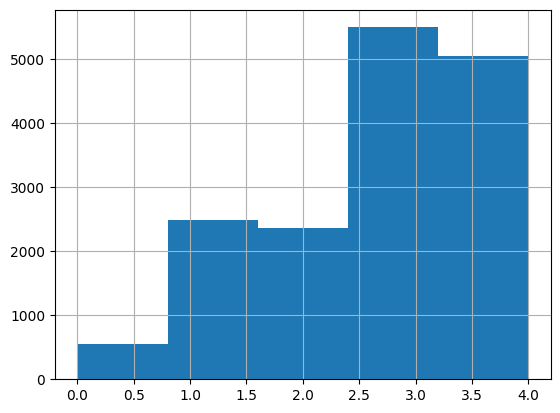

Bin 0.0 - 0.8: 543
Bin 0.8 - 1.6: 2478
Bin 1.6 - 2.4000000000000004: 2356
Bin 2.4000000000000004 - 3.2: 5493
Bin 3.2 - 4.0: 5051


In [125]:
#Histogram to know how many samples there are per class (mantle source end-member) after all the filtering done. 
label_data= normalized_final_data['labelSrNd']
print(label_data)
print(len(label_data))

label_data.hist(bins=5)  
plt.show()
hist, bins = np.histogram(label_data, bins=5) 

for i in range(len(hist)):
    print(f"Bin {bins[i]} - {bins[i+1]}: {hist[i]}")

In [126]:
#In this block it is being chose which scenario I want to test. For example, if True means that I do not input any feature specified in the columns=["....,...."] 
#Scenario 1: False--> All features are inputs: all isotopes inclusing Sr and Nd which were used for labeling and Pb, Sm and Rb.
#Scenario 2 and 3: True
drop_first_col= False

if drop_first_col:
    #Scenario 2: Sr-Nd not considered as input features  
    normalized_final_data= normalized_final_data.drop(columns=['sr87_sr86', 'nd143_nd144'])
    #Scenario 3: any isotope consider as input, only major and minor elements. 
    #normalized_final_data= normalized_final_data.drop(columns=['rb87_sr86', 'sr87_sr86', 'nd143_nd144', 'sm147_nd144', 'pb206_pb204', 'pb207_pb204', 'pb208_pb204'])

print(normalized_final_data)

       labelSrNd  latitude  longitude  rb87_sr86  sr87_sr86  nd143_nd144   
0              3  0.687148   0.861957  -0.000867   0.081755    -0.774560  \
1              3  0.687151   0.861957  -0.004441   0.077470    -0.427189   
2              3  0.687156   0.861949  -0.005243   0.054618    -0.320056   
3              3  0.705489   0.884736   0.000000  -0.108060     0.410398   
4              3  0.739313   0.893431   0.000000   0.091324    -0.540815   
...          ...       ...        ...        ...        ...          ...   
15916          1  0.000000   0.000000   0.000000  -0.206324     0.916846   
15917          1  0.000000   0.000000   0.000000  -0.203325     0.816205   
15918          1  0.000000   0.000000   0.000000  -0.212465     0.881135   
15919          1  0.000000   0.000000   0.000000  -0.204610     0.796727   
15920          1  0.000000   0.000000   0.000000  -0.204039     0.900613   

       sm147_nd144  pb206_pb204  pb207_pb204  pb208_pb204  ...    ta_ppm   
0        -0

In [127]:
#Dividing my data set for training (80%), validation (20%) and testing (20%)
from sklearn.model_selection import train_test_split

train_data, no_train_data = train_test_split(normalized_final_data, test_size=0.2, random_state=4)
#train_data.to_csv('../DataFP/train_data.csv',index=False)
print(len(train_data))

val_data, test_data = train_test_split(no_train_data, test_size=0.5, random_state=4)
#val_data.to_csv('../DataFP/val_data.csv',index=False)
print(len(val_data))

#test_data.to_csv('../DataFP/test_data.csv',index=False)
print(len(test_data))

12736
1592
1593


In [128]:
#Calling my data set
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data.values
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        sample = self.data[idx]
        x = sample[1:] #my features: chemical composition including the major and minor elements plus Sr and Nd isotopes if required
        y = sample[0] #mantle source label
        return x, y


datatrain = MyDataset(train_data)
train_loader = DataLoader(datatrain, batch_size=16, shuffle=True) #batch_size can be modified (and was in order to see if there is any impact on the results)
dataval=MyDataset(val_data)
val_loader= DataLoader(dataval, batch_size=32) 
datatest=MyDataset(test_data)
test_loader=DataLoader(datatest, batch_size=32)




In [130]:
#Defining my MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=0.0)  #Add dropout layer with dropout probability of 0.1
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, output_size)

        # Initialize the weights
        #init.xavier_uniform_(self.fc1.weight)
        #init.xavier_uniform_(self.fc2.weight)
        #init.xavier_uniform_(self.fc3.weight)
        #init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout layer
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout layer
        #Here I can "play" with the numer of hidden layers.
        #x = torch.relu(self.fc3(x))
        #x = torch.relu(self.fc4(x))
        #x = self.dropout(x)
        #x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        x=torch.softmax(x, dim=1)
        return x


#Hyperparameters
input_size = 54  #Number of input features depending on which scenario I am working on: Major and minor elements plus isotopes (including Sr-Nd?). This value depends on True or False in block 5.
hidden_size = 30 #Should be between input and output values. 
output_size = 5 #Mantle source types: DM, HIMU, EMI, BSE, PREMA
learning_rate = 0.001
num_epochs = 10000000 #It will stop anyway due to the stopping criteria (Early stopping) I am adding below. 

# Starting the model
model = MLP(input_size, hidden_size, output_size).to(device)

#Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0*1e-5) #weight decay is my regularizer

best_model = '../Results/best_model.csv' #Saving the model with the best accuracy in the validation to be used in the testing
tolerance = 50 #Treshold to stop the model if it does not get better (For the Early stopping)
aux_tolerance = tolerance
best_acc = 0
#Starting the loop for training and validation
for epoch in range(num_epochs):
    
    batch_predictions = []
    batch_true_labels = []
    train_loss=0.0
    
    #Training loop
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device) #I am using the GPU
        labels = labels.to(device)
        #Forward pass
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.long())

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

        #Convert output probabilities to predicted class labels
        _, predicted = torch.max(outputs.data, 1)
        
        #Accumulating the batch predictions and true labels to lists per each 
        batch_predictions.extend(predicted.tolist())
        batch_true_labels.extend(labels.tolist())
   
    #Calculating metrics for each epoch
    train_acc= accuracy_score(batch_true_labels, batch_predictions)  #Calculating the accuracy of all my batches from the accumulation of the batches predictions and true labels
    train_f1= f1_score(batch_true_labels, batch_predictions, average='weighted')
    train_loss/=i+1

    #Validation loop
    batch_val_predictions = []
    batch_val_true_labels = []
    val_loss=0.0
    
    for b, (inputs, labels) in enumerate(val_loader):
        with torch.no_grad():
            # Forward pass
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.long())
            val_loss+=loss.item()
            
            # Convert output probabilities to predicted class labels
            _, predicted = torch.max(outputs.data, 1)

            # Accumulating the batch predictions and true labels to lists per each 
            batch_val_predictions.extend(predicted.tolist())
            batch_val_true_labels.extend(labels.tolist())
    
    # Calculate metrics for each epoch
    val_acc= accuracy_score(batch_val_true_labels, batch_val_predictions)  #calculating the accuracy of all my batches from the accumulation of the batches predictions and true labels
    val_f1 = f1_score(batch_val_true_labels, batch_val_predictions, average='weighted')
    val_loss/=b+1

    #Early stopping
    #Comparing the results among my model to save the best one
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(),best_model )
        print("Model saved")
        aux_tolerance = tolerance #Re-starting the process as the "new" calculated accuracy is better than one found before. So, the tolerance goes again to the initial treshold
    else:
        aux_tolerance -= 1 #If my model continuously is performing not good enough, meaning the accuracy is not changing or it is small, then I am decreasing the tolerance to stop soon as it is not performing well anyway

    #Early Stopping itself
    if aux_tolerance == 0:
        print("Early stopping...")
        break

    # Compute and print training loss every 10 epochs
    if (epoch+1) % 10 == 0:
        to_print = f'Epoch {epoch+1}/{num_epochs}: '
        to_print += f'Train Loss: {train_loss:.4f}, '
        to_print+=f'Train Acc: {train_acc:.4f}, '
        to_print+=f'Train f1: {train_f1:.4f}, '
        to_print+= f'Val Loss: {val_loss:.4f}, ' 
        to_print+=f'Val Acc: {val_acc:.4f}, '
        to_print+=f'Val f1: {val_f1:.4f}'
        print(to_print)

print('Training finished')


Model saved
Model saved
Model saved
Model saved
Model saved
Model saved
Model saved
Model saved
Model saved
Model saved
Epoch 10/10000000: Train Loss: 1.1192, Train Acc: 0.7886, Train f1: 0.7181, Val Loss: 1.1161, Val Acc: 0.7940, Val f1: 0.7267
Model saved
Model saved
Epoch 20/10000000: Train Loss: 1.1098, Train Acc: 0.7966, Train f1: 0.7264, Val Loss: 1.1201, Val Acc: 0.7839, Val f1: 0.7184
Epoch 30/10000000: Train Loss: 1.1086, Train Acc: 0.7958, Train f1: 0.7256, Val Loss: 1.1104, Val Acc: 0.7946, Val f1: 0.7254
Epoch 40/10000000: Train Loss: 1.1054, Train Acc: 0.8003, Train f1: 0.7308, Val Loss: 1.1143, Val Acc: 0.7902, Val f1: 0.7231
Epoch 50/10000000: Train Loss: 1.1043, Train Acc: 0.8005, Train f1: 0.7334, Val Loss: 1.1165, Val Acc: 0.7871, Val f1: 0.7210
Model saved
Epoch 60/10000000: Train Loss: 1.1055, Train Acc: 0.7997, Train f1: 0.7326, Val Loss: 1.1181, Val Acc: 0.7852, Val f1: 0.7211
Epoch 70/10000000: Train Loss: 1.1028, Train Acc: 0.8022, Train f1: 0.7358, Val Loss: 1.

KeyboardInterrupt: 

In [131]:
#Testing loop

test_predictions = []
test_true_labels = []
test_loss=0.0

model.load_state_dict(torch.load(best_model))

for c, (inputs, labels) in enumerate(test_loader):
    with torch.no_grad():
        # Forward pass
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.long())
        test_loss+=loss.item()
        
        # Convert output probabilities to predicted class labels
        _, predicted = torch.max(outputs.data, 1)

        # Accumulating the batch predictions and true labels to lists per each 
        test_predictions.extend(predicted.tolist())
        test_true_labels.extend(labels.tolist())

test_acc= accuracy_score(test_true_labels,test_predictions)  
print(test_acc)
cm = confusion_matrix(test_true_labels, test_predictions)
report = classification_report(test_true_labels, test_predictions)
print(cm)
print(report)
cm_df = pd.DataFrame(cm, index=['DM', 'HIMU','EMI','BSE','PREMA'], columns=['DM_pred', 'HIMU_pred','EMI_pred','BSE_pred','PREMA_pred'])
cm_df.to_csv('../Results/confusion_matrix_test.csv')
with open('../Results/classification_report_test.txt', 'w') as f:
    f.write(report)
print(cm_df)



0.7909604519774012
[[  6   2  27   1  18]
 [  0   7   0   3 244]
 [  0   0 249   5   0]
 [  2   0   8 539   9]
 [  0   1   0  13 459]]
              precision    recall  f1-score   support

         0.0       0.75      0.11      0.19        54
         1.0       0.70      0.03      0.05       254
         2.0       0.88      0.98      0.93       254
         3.0       0.96      0.97      0.96       558
         4.0       0.63      0.97      0.76       473

    accuracy                           0.79      1593
   macro avg       0.78      0.61      0.58      1593
weighted avg       0.80      0.79      0.73      1593

       DM_pred  HIMU_pred  EMI_pred  BSE_pred  PREMA_pred
DM           6          2        27         1          18
HIMU         0          7         0         3         244
EMI          0          0       249         5           0
BSE          2          0         8       539           9
PREMA        0          1         0        13         459
